# Project 1 Machine Learning
## Build predictive models to predict a classifiction, i.e., player's hand (righty or lefity) by using the ATP historic match data or if a palyer wins a match based on the historic match results.


### Used OLS and Lasso to exam the importance of the features and evaluate the relationship between the predictor variables and response variable

### Used the below models to learn the predictor variables and predict the response variable

   KNeighborsClassifier

   LogisticRegression

   Bagging - RandomForestClassifier

   Boosting - Gradient Boosting

### Used train_test_split, cross_val_score, GridSearchCV to tune and learn models

### Used learning_curve and other metric to compare the model performance


In [1379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed
import seaborn as sns; sns.set(color_codes=True)
from os import listdir
import re
from scipy.stats import stats
from scipy import stats
from statsmodels.nonparametric.kernel_regression import KernelReg

import matplotlib as mpl
import statsmodels.formula.api as sm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Lasso, Ridge, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score, SCORERS
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.dummy import DummyRegressor

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [1247]:
df = pd.read_csv('data/RL_v.csv')
df2 = pd.read_csv('data/RL_h.csv')
df_all = pd.read_csv('data/all_v_00_19.csv')

Add a few calcualted columns

In [1343]:
df_all.loc[df_all.player_hand=='R', 'player_hand_flag'] = 1
df_all.loc[df_all.player_hand=='L', 'player_hand_flag'] = 0

In [1252]:
df_all['svpt_won_pct']= np.around((df_all.sv1stWon + df_all.sv2ndWon)/df_all.svpt,2)
df_all['svpt_std_var']=df_all.svpt - df_all.SvGms*4
df_all['bpSaved_pct'] = np.around(df_all.bpSaved/df_all.bpFaced,2)
df_all.bpSaved_pct.fillna(0, inplace=True)

In [ ]:
df.loc[df.player_hand=='R', 'player_hand_flag'] = 1
df.loc[df.player_hand=='L', 'player_hand_flag'] = 0

In [1249]:
df.loc[(df.surface=='Hard'), 'surface_id'] = 1
df.loc[(df.surface=='Clay'), 'surface_id'] = 2
df.loc[(df.surface=='Grass'), 'surface_id'] = 3
df.loc[(df.surface=='Carpet'), 'surface_id'] = 4

In [1250]:
df.loc[(df.tourney_level=='A'), 'tourney_level_id'] = 1
df.loc[(df.tourney_level=='G'), 'tourney_level_id'] = 2
df.loc[(df.tourney_level=='M'), 'tourney_level_id'] = 3

In [1251]:
df.loc[(df.player_rank >=1) & (df.player_rank<=30), 'player_rank_group'] = 1
df.loc[(df.player_rank >=11) & (df.player_rank<=60), 'player_rank_group'] = 2
df.loc[(df.player_rank >=61) & (df.player_rank<=100), 'player_rank_group'] = 3
df.loc[(df.player_rank >=101), 'player_rank_group'] = 4

add svpt_won_pct and bpSaved_pct to make serving data at the same scale

In [1253]:
df['svpt_won_pct']= np.around((df.sv1stWon + df.sv2ndWon)/df.svpt,2)

In [1254]:
# calculate how many additaionl serves to win the serving game.  
df['svpt_std_var']=df.svpt - df.SvGms*4

In [1255]:
df['bpSaved_pct'] = np.around(df.bpSaved/df.bpFaced,2)
df.bpSaved_pct.fillna(0, inplace=True)

In [1256]:
df.columns

Index(['Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'tourney_date', 'match_num', 'player_id', 'player_name', 'player_hand',
       'player_ht', 'player_ioc', 'player_age', 'score', 'best_of', 'round',
       'minutes', 'ace', 'df', 'svpt', 'sv1stIn', 'sv1stWon', 'sv2ndWon',
       'SvGms', 'bpSaved', 'bpFaced', 'player_rank', 'player_rank_points',
       'ace_pct', 'df_pct', 'sv1stIn_pct', 'sv2ndIn_pct', 'sv1stWon_pct',
       'sv2ndWon_pct', 'GmsWon', 'GmsLoss', 'year', 'opponent_id',
       'opponent_name', 'won_flag', 'player_age_bucket', 'player_hand_flag',
       'surface_id', 'tourney_level_id', 'player_rank_group', 'svpt_won_pct',
       'svpt_std_var', 'bpSaved_pct'],
      dtype='object')

There are 14 rows have data issues on svpt_won_pct.  Since volume is small so just ignore it.

In [1257]:
df[df.svpt_won_pct>=1][['score','sv1stIn','sv1stIn_pct','sv1stWon','svpt','svpt_won_pct', 'svpt_std_var', 'SvGms','ace_pct','df_pct','GmsWon','GmsLoss','won_flag','sv2ndWon','ace','df','bpFaced','bpSaved', 'player_age', 'player_rank']].head()

,score,sv1stIn,sv1stIn_pct,sv1stWon,svpt,svpt_won_pct,svpt_std_var,SvGms,ace_pct,df_pct,GmsWon,GmsLoss,won_flag,sv2ndWon,ace,df,bpFaced,bpSaved,player_age,player_rank
2460,6-2 3-6 6-4,32.0,0.70,47.0,46.0,1.78,-6.0,13.0,0.07,0.15,15.0,12.0,1,35.0,3.0,7.0,9.0,5.0,29.51,127.0
2461,6-2 3-6 6-3,27.0,0.52,38.0,52.0,1.38,0.0,13.0,0.12,0.08,15.0,11.0,1,34.0,6.0,4.0,3.0,1.0,22.06,35.0
2462,3-6 7-5 6-2,41.0,0.73,56.0,56.0,1.46,0.0,14.0,0.14,0.04,16.0,13.0,1,26.0,8.0,2.0,3.0,1.0,24.84,37.0
2463,7-6(2) 6-4,36.0,0.73,42.0,49.0,1.43,5.0,11.0,0.06,0.10,12.0,10.0,1,28.0,3.0,5.0,1.0,0.0,24.01,21.0
2464,6-4 3-6 6-3,39.0,0.70,47.0,56.0,1.41,0.0,14.0,0.30,0.14,15.0,13.0,1,32.0,17.0,8.0,3.0,2.0,22.06,35.0


In [1258]:
df[df.svpt_won_pct>=1].player_id.count()

14

In [1259]:
df[(df.tourney_id=='2003-1536') & (df.player_id==103819)][['score','sv1stIn','sv1stIn_pct','sv1stWon','svpt','svpt_won_pct', 'svpt_std_var', 'SvGms','ace_pct','df_pct','GmsWon','GmsLoss','won_flag','sv2ndWon','ace','df','bpFaced','bpSaved', 'player_age', 'player_rank']]

,score,sv1stIn,sv1stIn_pct,sv1stWon,svpt,svpt_won_pct,svpt_std_var,SvGms,ace_pct,df_pct,GmsWon,GmsLoss,won_flag,sv2ndWon,ace,df,bpFaced,bpSaved,player_age,player_rank
2466,4-6 7-6(3) 6-4,42.0,0.63,52.0,67.0,1.46,3.0,16.0,0.15,0.06,16.0,16.0,1,46.0,10.0,4.0,8.0,7.0,22.18,3.0


Functions

In [1358]:
def plot_ol_coef(axis_names, f):
    # use Ordinary Least Squares to exam the relationship between the predictor variables (the X) and the response (the y)
    reg = sm.ols(f, data=df).fit()
    reg_results = reg.summary()
    print(reg_results)
    # print
    print('params:')
    print(reg.params)
    print()
    print()
    print('conf_int:')
    print(reg.conf_int())
    print()
    print()
    print('err_series:')
    err_series = reg.params - reg.conf_int()[0]
    print(err_series)
    print()
    print()
    print('coef_df:')
    coef_df = pd.DataFrame({'coef': reg.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })
    print(coef_df)
    print()
    print()
    
    # plot
    fig, ax = plt.subplots(figsize=(12 ,5))
    # plot error bar
    coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, #color='none', 
             yerr='err', 
             legend=False)
    ax.set_ylabel('coef')
    ax.set_xlabel('columns')
    # scatter plot 
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')
    _ = ax.set_xticklabels(axis_columns, 
                       rotation=45, fontsize=16)
    
    return reg.params, reg.conf_int(), err_series, coef_df

In [1261]:
#sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

In [1262]:
def display_plot(cv_scores, cv_scores_std):
    alpha_space = np.logspace(-4, 0, 50)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

In [1263]:
#from sklearn.linear_model import Lasso
#from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
def plot_lasso_alpha(X,y):
    alpha_space = np.logspace(-4, 0, 50)
    lasso_scores = []
    lasso_scores_std = []
    
    # Create a ridge regressor: ridge
    lasso = Lasso(normalize=True)
    
    # Compute scores over range of alphas
    for alpha in alpha_space:
        # Specify the alpha value to use: ridge.alpha
        lasso.alpha = alpha
        
        # Perform 5-fold CV: lasso_cv_scores
        lasso_cv_scores = cross_val_score(lasso,X,y,cv=5)
        
        # Append the mean of ridge_cv_scores to ridge_scores
        lasso_scores.append(np.mean(lasso_cv_scores))
        
        # Append the std of ridge_cv_scores to ridge_scores_std
        lasso_scores_std.append(np.std(lasso_cv_scores))
        
    # Display the plot
    display_plot(lasso_scores, lasso_scores_std)
    return lasso_scores, lasso_scores_std
  

In [1264]:
def plot_lasso_features(names, X, y, alpha=0.01):
    
    plt.figure(figsize=(8,8))
    
    lasso = Lasso(alpha=alpha)
    lasso_coef = lasso.fit(X, y).coef_ 
    _ = plt.plot(range(len(names)), lasso_coef) 
    _ = plt.xticks(range(len(names)), names, rotation=60) 
    _ = plt.ylabel('Coefficients') 
    plt.show() 

In [1265]:
def make_CV_models(X, y):
    '''performs grid searches to find all the best models for dataset X, y'''

    model_dict = {
            #'KRR'    : GridSearchCV(X, y, KernelRidge(), param_grid={"alpha": np.logspace(-10, 2, 300), "gamma": np.logspace(-10, -1, 100), "kernel" : ['rbf']}),
          #  'SVR'   : GridSearchCV(X, y, SVR(), param_grid={"C": np.logspace(-1, 4, 20), "epsilon": np.logspace(-2, 2, 20)}),
           # 'Ridge' : GridSearchCV(X, y, Ridge(), param_grid={"alpha": np.logspace(-6, 6, 150)} ),
           # 'Lasso' : GridSearchCV(X, y, Lasso(max_iter = 20000), param_grid={"alpha": np.logspace(-2, 6, 100)} ),
          #  'BR'    : GridSearchCV(X, y, BayesianRidge(), param_grid={"alpha_1": np.logspace(-13,-5,10),"alpha_2": np.logspace(-9,-3,10), "lambda_1": np.logspace(-10,-5,10),"lambda_2": np.logspace(-11,-4,10)}) ,
          #  'GBoost': GridSearchCV(X, y, GradientBoostingRegressor(), param_grid={"n_estimators": np.linspace(5, 350, 100).astype('int')} ),
          #  'RF'    : GridSearchCV(X, y, RandomForestRegressor(), param_grid={"n_estimators": np.linspace(5, 100, 50).astype('int')}, ),
            'kNN'   : GridSearchCV(X, y, KNeighborsRegressor(), param_grid={"n_neighbors": list(range(1, 31))} )#,
          #  'mean'  : DummyRegressor(strategy='mean'),
            }

    return model_dict

In [1266]:
def knn_k_grid_search(X, y, n_CV=5):
    #from sklearn.grid_search import GridSearchCV 
    
    '''
    knn = KNeighborsClassifier()
     
    k_range = np.arange(1,31)
    
    params = {"n_neighbors": k_range,  
          "metric": ["euclidean", "cityblock"]} 
    grid = GridSearchCV(estimator=knn, param_grid=params, cv=n_CV, scoring='accuracy', n_jobs=-1) #scoring='roc_auc') 
    grid.fit(X, y) 
    print(grid.best_score_) 
    print(grid.best_estimator_.n_neighbors)
    '''
    k_range = list(range(1, 31))
    print(k_range)
    
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    
    knn = KNeighborsClassifier()
    
    # instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=n_CV, scoring='accuracy', n_jobs=-1) #scoring='roc_auc'
    # fit the grid with data
    grid.fit(X, y)

    grid_mean_scores = grid.cv_results_['mean_test_score']
    print('')
    print('Mean Test Score')
    print(grid_mean_scores.mean())
    
    knn_neighbors = grid.best_params_
    print(knn_neighbors)
    print(grid.best_score_)
    
    # plot the results
    # this is identical to the one we generated above
    plt.plot(k_range, grid_mean_scores, marker='o')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    
    return grid, grid.best_estimator_.n_neighbors

In [1267]:
def knn_cross_val_scores(X, y, k, cv=5):
    # K-fold cross-validation

    knn = KNeighborsClassifier(n_neighbors=k)
    
    cv_scores = cross_val_score(knn, X, y, cv=n_CV, scoring='roc_auc', n_jobs=-1)
    print('CV Scores:')
    print(cv_scores)
    print('Average CV Score:')
    print(cv_scores.mean())
    print()
    print()
    
    return cv_scores

In [1268]:
def get_cross_val_scores(model, X, y, cv=5):
    # K-fold cross-validation
    
    cv_scores = cross_val_score(model, X, y, cv=n_CV, scoring='roc_auc', n_jobs=-1)
    print('CV Scores:')
    print(cv_scores)
    print('Average CV Score:')
    print(cv_scores.mean())
    print()
    print()
    
    return cv_scores

In [1269]:
def run_train_testing_split(model, X_train, X_test, y_train, y_test):
    # train and test split
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)  
    
    #knn = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(mean_squared_error(y_test, y_pred))
    print (r2_score(y_test, y_pred))
    
    # ROC Curve
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print('ROC AUC Score: ' + str(auc_score))    
    print()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # False Positive, True Positive, Threshold

    plt.figure(figsize=(12,12))
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [1270]:
def knn_cross_val_k_search(X,y,cv=5):
    # parameter tuning using cross_val_score
    # Goal: To select the best value of k for KNN model to predict
    
    k_range = range(1, 31)
    
    # list of scores from k_range
    k_scores = []
    
    #loop through reasonable values of k
    for k in k_range: 
        # run KNeighborsClassifier with k neighbours
        knn = KNeighborsClassifier(n_neighbors=k)
        # obtain cross_val_score for KNeighborsClassifier with k neighbours
        scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
        # append mean of scores for k neighbors to k_scores list
        k_scores.append(scores.mean())
    print(k_scores)
    
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.plot(k_range, k_scores, marker='o')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    return k_range, k_scores

In [1271]:
def plot_learning_curve(model, X, y):
    # visualize the effect of the number of observations on the performance metric
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(model,#KNeighborsClassifier(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        shuffle=True,
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
    
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.5)#"#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="b", alpha=0.5)#"#DDDDDD")

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [1272]:
n_CV = 10
p_test_size = 0.2
p_random_state= 42

# KNN

## Machine learning for Data Set 1 of selected predicotr variables (Xs) and response (won_flag) 

### OLS to exam coef betwen Xs and y

Use Ordinary Least Squares to exam the relationship between the predictor variables (the X) and the response (the y)

                            OLS Regression Results                            
Dep. Variable:               won_flag   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     1237.
Date:                Sun, 08 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:45:37   Log-Likelihood:                -9412.5
No. Observations:               20132   AIC:                         1.885e+04
Df Residuals:                   20120   BIC:                         1.894e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7774      0.021     36.869   

(Intercept       0.777405
 sv1stIn        -0.001108
 sv1stWon        0.012274
 svpt            0.001151
 sv2ndWon        0.011496
 ace            -0.012757
 df             -0.003447
 bpFaced        -0.135586
 bpSaved         0.145734
 player_age     -0.005393
 player_rank    -0.000433
 svpt_std_var   -0.011491
 dtype: float64,                      0         1
 Intercept     0.736076  0.818734
 sv1stIn      -0.002829  0.000612
 sv1stWon      0.009441  0.015107
 svpt         -0.001347  0.003649
 sv2ndWon      0.008603  0.014390
 ace          -0.014108 -0.011406
 df           -0.006171 -0.000723
 bpFaced      -0.143333 -0.127839
 bpSaved       0.137286  0.154181
 player_age   -0.006779 -0.004007
 player_rank  -0.000496 -0.000370
 svpt_std_var -0.013153 -0.009829, Intercept       0.041329
 sv1stIn         0.001721
 sv1stWon        0.002833
 svpt            0.002498
 sv2ndWon        0.002893
 ace             0.001351
 df              0.002724
 bpFaced         0.007747
 bpSaved         0.008

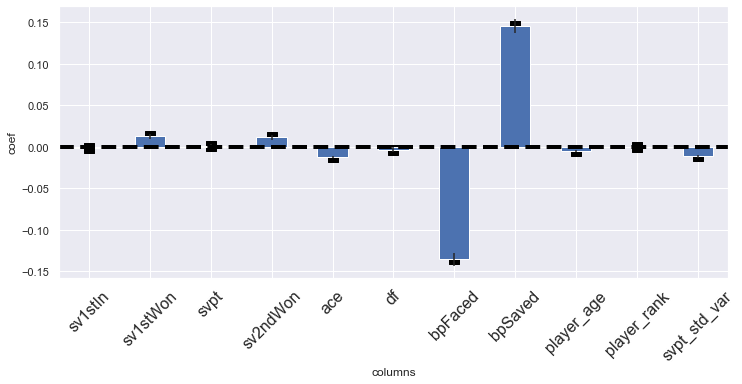

In [1273]:
axis_columns= ['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df','bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var']

f = 'won_flag ~ sv1stIn + sv1stWon + svpt + sv2ndWon + ace + df + bpFaced + bpSaved + player_age + player_rank + svpt_std_var'

plot_ol_coef(axis_columns, f)

In [1274]:
model_columns=['sv1stIn', 'sv1stWon','svpt','sv2ndWon','ace','df','bpFaced', 'bpSaved', 'svpt_std_var']

names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

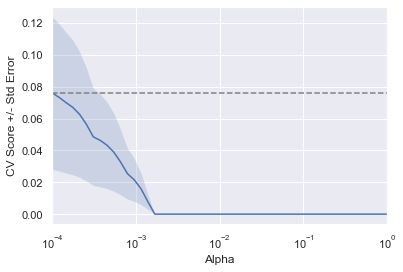

([0.07597072018929614,
  0.07324605797823291,
  0.07001225925692642,
  0.06697739016869615,
  0.06258544077563907,
  0.056264648887037416,
  0.04848116624859582,
  0.04632226625998748,
  0.04325584850798627,
  0.03888455359449021,
  0.03263290477963223,
  0.02539295374864674,
  0.02145100741875485,
  0.01580285802581729,
  0.007689051693476734,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -

In [1275]:
plot_lasso_alpha(X,y)

### Apply the selected alpha to Lasso model to exam the significant features 

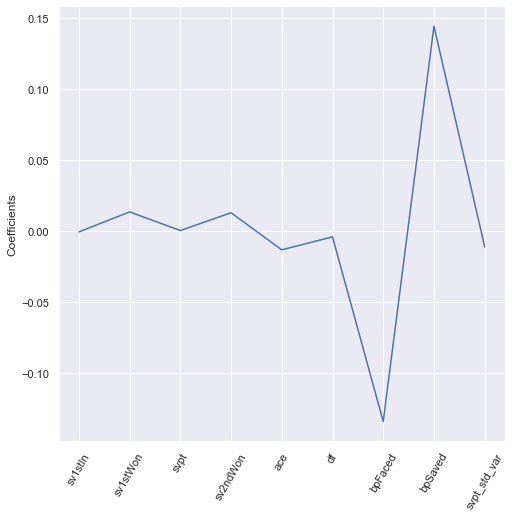

In [1276]:
plot_lasso_features(names, X, y, 0.001)

### Choose the best n_neighbors 

[0.7157406518617965, 0.7053085278098288, 0.735794901165244, 0.7335590298209103, 0.7503858168240205, 0.7469101780171012, 0.7577753488965424, 0.755976536380422, 0.7600737564325881, 0.7588317512573728, 0.7642956630804437, 0.7638606489991077, 0.7657857291936546, 0.7659101074467004, 0.7672765674574211, 0.7692628726446229, 0.7696975013216165, 0.7684557278586613, 0.7681445899551911, 0.7692624483500012, 0.7699453311224389, 0.7705662951552352, 0.7709387731407075, 0.7726774799518035, 0.7721180106515705, 0.7728632366978909, 0.7716841923924005, 0.772428878431741, 0.7724292641715512, 0.7739195234901347]


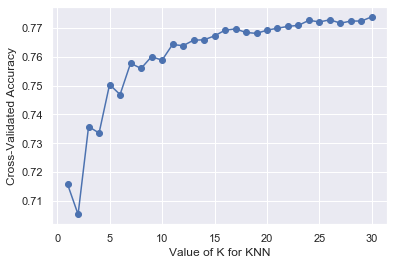

In [1277]:
# use cross val search best k from the list of k
k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.7603973921142504
{'n_neighbors': 30}
0.7739211425023285


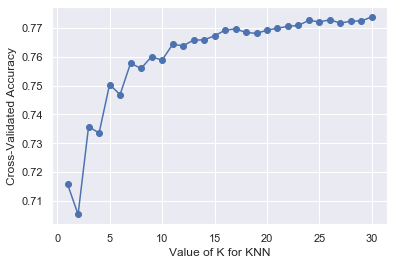

In [1278]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1998
           1       0.77      0.77      0.77      2029

    accuracy                           0.77      4027
   macro avg       0.77      0.77      0.77      4027
weighted avg       0.77      0.77      0.77      4027

[[1543  455]
 [ 466 1563]]
0.22870623292773776
0.08512085274036973
ROC AUC Score: 0.8649106227962808



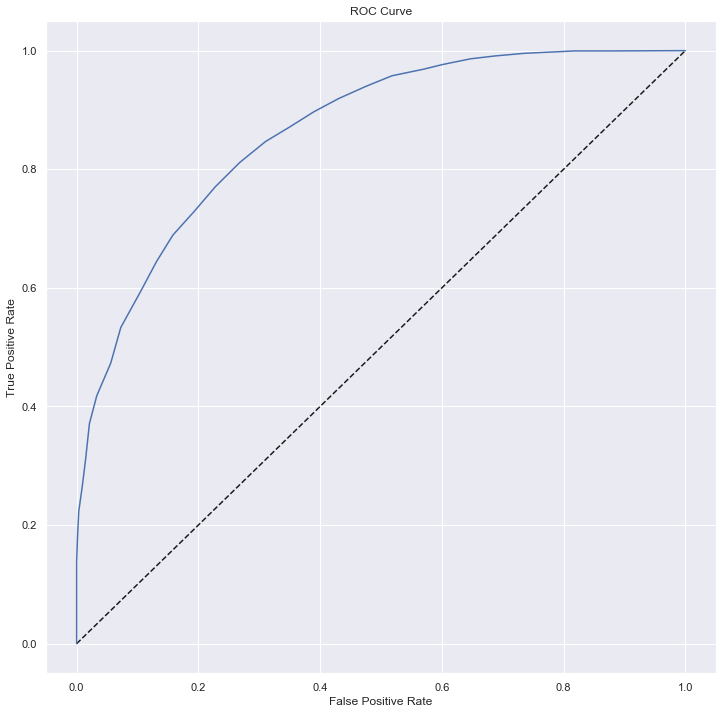

In [1280]:
knn = KNeighborsClassifier(n_neighbors=k)
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

In [1281]:
get_cross_val_scores(KNeighborsClassifier(n_neighbors=k), X_test, y_test, n_CV)

CV Scores:
[0.8170936  0.81454433 0.88229064 0.87631773 0.83652709 0.86125616
 0.84146552 0.84305419 0.79644528 0.85194537]
Average CV Score:
0.8420939912090326




array([0.8170936 , 0.81454433, 0.88229064, 0.87631773, 0.83652709,
       0.86125616, 0.84146552, 0.84305419, 0.79644528, 0.85194537])

### Exam learninig performance¶ 

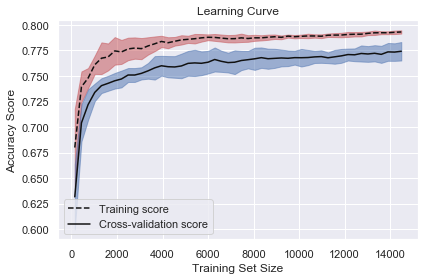

In [1282]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

## Machine learning for Data Set 2 of selected predicotr variables (Xs) and response (won_flag) 

### OLS to exam coef betwen Xs and y

Use Ordinary Least Squares to exam the relationship between the predictor variables (the X) and the response (the y)

In [1359]:
axis_columns= ['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct', 'bpSaved_pct']

f = 'won_flag ~ sv1stIn_pct + sv1stWon_pct + svpt_won_pct+ sv2ndWon_pct + ace_pct + df_pct + bpSaved_pct'

                            OLS Regression Results                            
Dep. Variable:               won_flag   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     1744.
Date:                Sun, 08 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:47:53   Log-Likelihood:                -9837.9
No. Observations:               20132   AIC:                         1.969e+04
Df Residuals:                   20124   BIC:                         1.976e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.5664      0.043    -36.383   

(Intercept      -1.566355
 sv1stIn_pct    -0.110523
 sv1stWon_pct    0.488141
 svpt_won_pct    2.902108
 sv2ndWon_pct    0.237768
 ace_pct        -0.755669
 df_pct         -0.494373
 bpSaved_pct     0.187282
 dtype: float64,                      0         1
 Intercept    -1.650740 -1.481969
 sv1stIn_pct  -0.244251  0.023204
 sv1stWon_pct -0.611241  1.587524
 svpt_won_pct  1.805482  3.998734
 sv2ndWon_pct -0.861684  1.337221
 ace_pct      -0.863901 -0.647436
 df_pct       -0.708434 -0.280312
 bpSaved_pct   0.167466  0.207098, Intercept       0.084385
 sv1stIn_pct     0.133727
 sv1stWon_pct    1.099382
 svpt_won_pct    1.096626
 sv2ndWon_pct    1.099452
 ace_pct         0.108232
 df_pct          0.214061
 bpSaved_pct     0.019816
 dtype: float64,        coef       err       varname
 0 -0.110523  0.133727   sv1stIn_pct
 1  0.488141  1.099382  sv1stWon_pct
 2  2.902108  1.096626  svpt_won_pct
 3  0.237768  1.099452  sv2ndWon_pct
 4 -0.755669  0.108232       ace_pct
 5 -0.494373  0.214061  

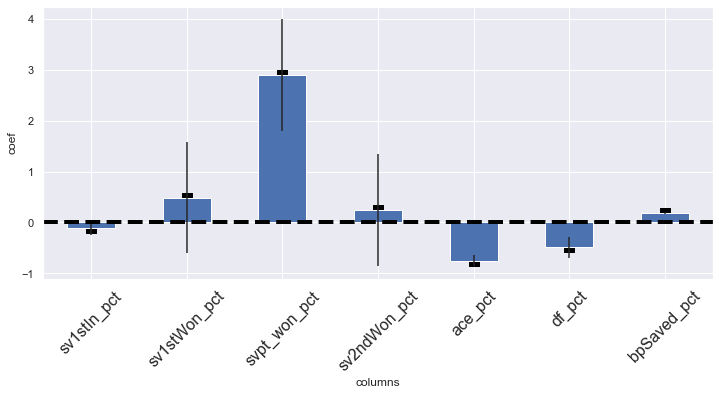

In [1284]:
plot_ol_coef(axis_columns, f)

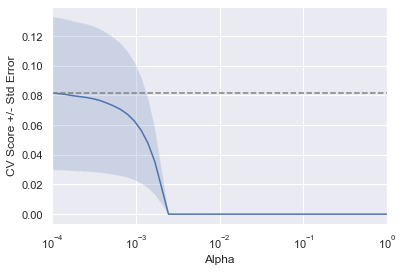

([0.08155531912299578,
  0.08114158418633104,
  0.0805742558977433,
  0.0797902700485535,
  0.07919137528478712,
  0.0785651069215781,
  0.07769774718282252,
  0.07648837861680773,
  0.07479209457655338,
  0.07282521143532047,
  0.07048205410151584,
  0.06725445330557615,
  0.06277702082283405,
  0.05652552896599905,
  0.04774605911282996,
  0.035352155310960656,
  0.01777545202946058,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.71153807

In [1360]:
# use percentage to re-scale the date
# run Lasso to find out the best alpha
model_columns= ['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct', 'bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values
plot_lasso_alpha(X,y)

### Apply the selected alpha to Lasso model to exam the significant features 

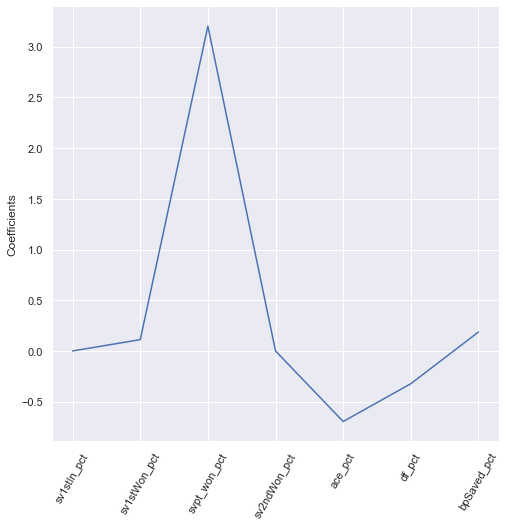

In [1287]:
plot_lasso_features(names, X, y, 0.0001)

In [1288]:
# split data into train and testing set
model_columns=['svpt_won_pct','ace_pct','df_pct','bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

### Choose the best n_neighbors 

[0.7336240346228053, 0.7274752731568255, 0.7556039429701351, 0.7572802681921568, 0.7681456317018832, 0.7684547637487553, 0.7723038061441653, 0.7754101690756918, 0.7788238501089186, 0.7801278899757536, 0.7850343766224575, 0.7838542904744271, 0.7857168736550849, 0.7845998637536702, 0.7867114727490124, 0.786773083098086, 0.7878910186983672, 0.7853450899437624, 0.7882638828549651, 0.7897537563858144, 0.7890706419490405, 0.7893188192224053, 0.7912438999441156, 0.7916161079500599, 0.792113118216128, 0.792920764645954, 0.7929825294059692, 0.7919267055590065, 0.7939755084789567, 0.7922988749622153]


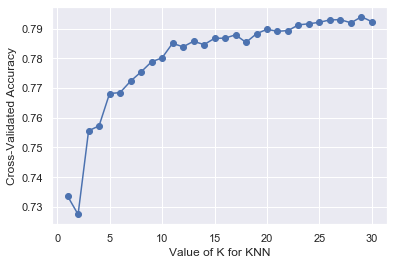

In [1290]:
# use cross val search best k from the list of k
k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.779956535237504
{'n_neighbors': 29}
0.7939770257683949


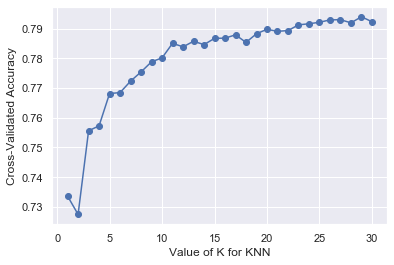

In [1291]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      1998
           1       0.79      0.80      0.79      2029

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

[[1561  437]
 [ 407 1622]]
0.20958529923019617
0.16160912020941587
ROC AUC Score: 0.8806528312442555



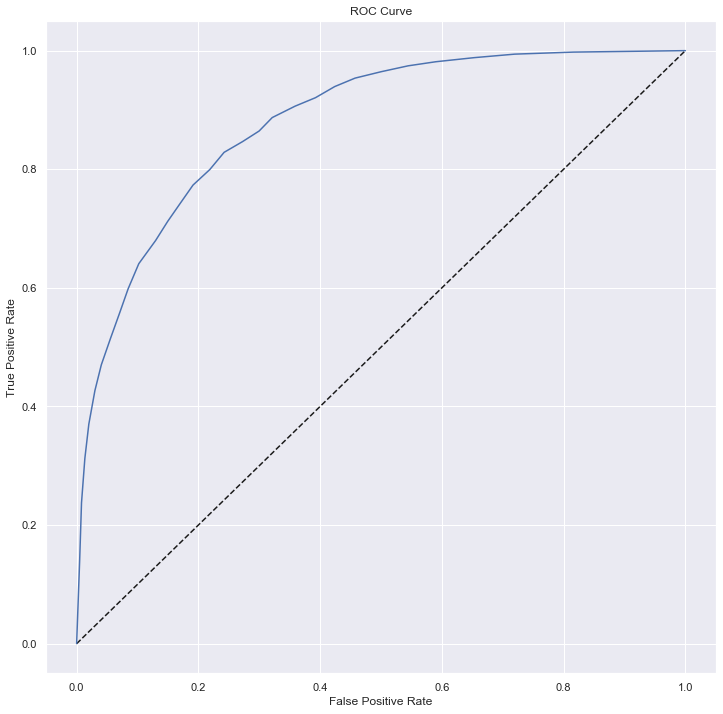

In [1293]:
knn = KNeighborsClassifier(n_neighbors=k)
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

In [1294]:
get_cross_val_scores(KNeighborsClassifier(n_neighbors=k), X_test, y_test, n_CV)

CV Scores:
[0.84587438 0.8735468  0.89878079 0.90094828 0.88807882 0.88695813
 0.86447044 0.85495074 0.84550833 0.89452212]
Average CV Score:
0.8753638819738845




array([0.84587438, 0.8735468 , 0.89878079, 0.90094828, 0.88807882,
       0.88695813, 0.86447044, 0.85495074, 0.84550833, 0.89452212])

### Exam learninig performance¶ 

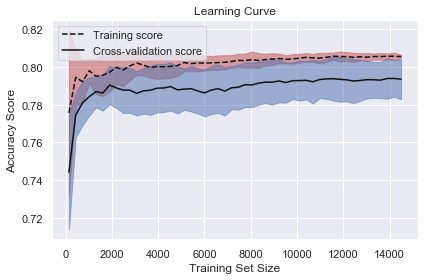

In [1295]:
#plot_learning_curve(KNeighborsClassifier(), X_train, y_train)
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

## Machine learning for Data Set 3 of selected predicotr variables (Xs) and response (won_flag) 

Further reduce features to most significant features, svpt_won_pct and bpSaved_pct

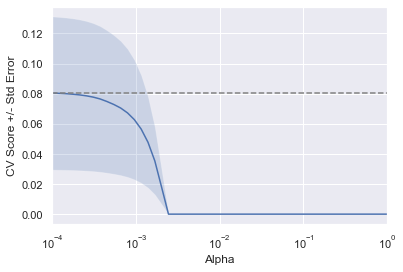

([0.0804108728452528,
  0.08022710214638303,
  0.07998050791138611,
  0.07964677162047004,
  0.07919137676955072,
  0.07856514109426253,
  0.07769774840675103,
  0.07648840713148894,
  0.07479210691084226,
  0.07282521143532047,
  0.07048205410151584,
  0.06725445330557615,
  0.06277702082283405,
  0.05652552896599905,
  0.04774605911282996,
  0.035352155310960656,
  0.01777545202946058,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538074772761e-08,
  -7.711538

In [1373]:
# use percentage to re-scale the date
# run Lasso to find out the best alpha
model_columns=['svpt_won_pct', 'bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['won_flag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

plot_lasso_alpha(X,y)

### Choose the best n_neighbors

[0.7195871097908928, 0.7149927641916157, 0.7457909693891833, 0.7474662919464877, 0.7615628206478647, 0.7624945365567772, 0.7687034424742888, 0.7683308105571144, 0.773174799518994, 0.7717465751795736, 0.7746031786048237, 0.7748518185359259, 0.7780191358575684, 0.7788253166294721, 0.7798821432369999, 0.7810600688299472, 0.7829231535106975, 0.7831089872705599, 0.7839789386111531, 0.7853446657449885, 0.7843517640212437, 0.7855923413265652, 0.7852824767861996, 0.785406931573781, 0.7862140381883227, 0.7862136137020052, 0.7886979324909278, 0.7882631110878009, 0.7887601601003762, 0.7884501408615252]


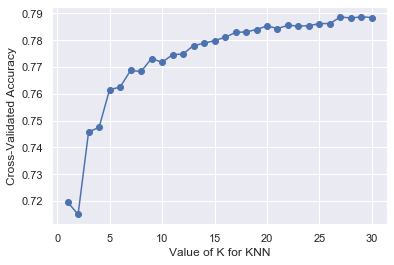

In [1297]:
# use cross val search best k from the list of k
k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.7734575183690365
{'n_neighbors': 29}
0.7887612542688606


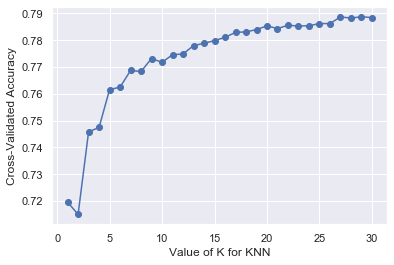

In [1298]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

In [1299]:
knn_cross_val_scores(X_test, y_test, k, n_CV)

CV Scores:
[0.85018473 0.87405172 0.89278325 0.89490148 0.87682266 0.89156404
 0.85476601 0.86926108 0.83617595 0.89370118]
Average CV Score:
0.8734212108192526




array([0.85018473, 0.87405172, 0.89278325, 0.89490148, 0.87682266,
       0.89156404, 0.85476601, 0.86926108, 0.83617595, 0.89370118])

              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1998
           1       0.79      0.79      0.79      2029

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

[[1574  424]
 [ 432 1597]]
0.2125651850012416
0.1496888707337204
ROC AUC Score: 0.8786177749953009



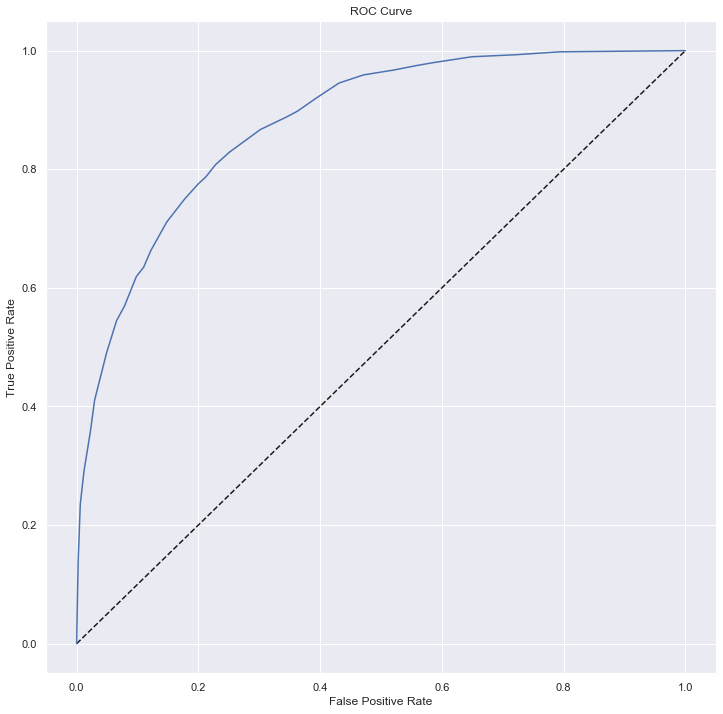

In [1300]:
knn = KNeighborsClassifier(n_neighbors=k)
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

In [1301]:
get_cross_val_scores(KNeighborsClassifier(n_neighbors=k), X_test, y_test, n_CV)

CV Scores:
[0.85018473 0.87405172 0.89278325 0.89490148 0.87682266 0.89156404
 0.85476601 0.86926108 0.83617595 0.89370118]
Average CV Score:
0.8734212108192526




array([0.85018473, 0.87405172, 0.89278325, 0.89490148, 0.87682266,
       0.89156404, 0.85476601, 0.86926108, 0.83617595, 0.89370118])

### Exam learninig performance¶ 

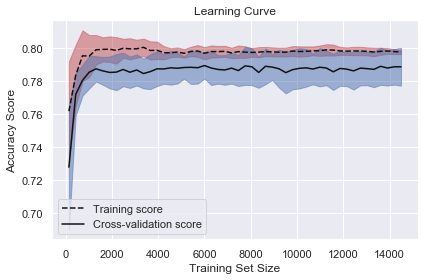

In [1302]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

# Can we predict player hand based on the historic match data?

Change response y to player_hand_flag and run through the KNN models

                            OLS Regression Results                            
Dep. Variable:       player_hand_flag   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     40.12
Date:                Sun, 08 Mar 2020   Prob (F-statistic):           1.91e-56
Time:                        22:50:26   Log-Likelihood:                -14472.
No. Observations:               20132   AIC:                         2.896e+04
Df Residuals:                   20124   BIC:                         2.902e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9071      0.054     16.738   

(Intercept       0.907117
 sv1stIn_pct    -0.830106
 sv1stWon_pct   -0.587064
 svpt_won_pct    0.962820
 sv2ndWon_pct   -0.996723
 ace_pct         0.233843
 df_pct         -1.254435
 bpSaved_pct    -0.046242
 dtype: float64,                      0         1
 Intercept     0.800890  1.013345
 sv1stIn_pct  -0.998448 -0.661765
 sv1stWon_pct -1.971011  0.796884
 svpt_won_pct -0.417657  2.343298
 sv2ndWon_pct -2.380759  0.387313
 ace_pct       0.097596  0.370090
 df_pct       -1.523903 -0.984966
 bpSaved_pct  -0.071188 -0.021297, Intercept       0.106228
 sv1stIn_pct     0.168342
 sv1stWon_pct    1.383947
 svpt_won_pct    1.380478
 sv2ndWon_pct    1.384036
 ace_pct         0.136247
 df_pct          0.269469
 bpSaved_pct     0.024946
 dtype: float64,        coef       err       varname
 0 -0.830106  0.168342   sv1stIn_pct
 1 -0.587064  1.383947  sv1stWon_pct
 2  0.962820  1.380478  svpt_won_pct
 3 -0.996723  1.384036  sv2ndWon_pct
 4  0.233843  0.136247       ace_pct
 5 -1.254435  0.269469  

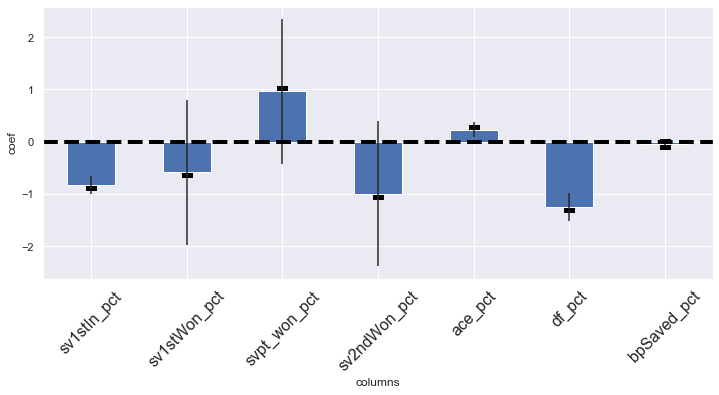

In [1303]:
axis_columns= ['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct', 'bpSaved_pct']
f = 'player_hand_flag ~ sv1stIn_pct + sv1stWon_pct + svpt_won_pct+ sv2ndWon_pct + ace_pct + df_pct +  bpSaved_pct'
#f = 'player_hand_flag ~ sv1stIn_pct + sv1stWon_pct + svpt_won_pct+ sv2ndWon_pct + ace_pct + df_pct + bpFaced + bpSaved + player_age + player_rank + svpt_std_var + bpSaved_pct'

plot_ol_coef(axis_columns, f)

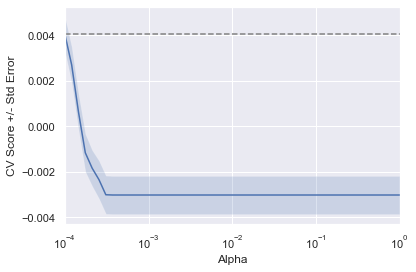

([0.004061674011785299,
  0.0027058482448700572,
  0.0006247595091624758,
  -0.0011698498952424474,
  -0.0018467454978805975,
  -0.0023544192456606437,
  -0.0030172536437925055,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.0030287725005363696,
  -0.00302877250

In [1362]:
# use percentage to re-scale the date
# run Lasso to find out the best alpha
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
#['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct', 'bpSaved_pct']

names= df[model_columns].columns
X = df[model_columns].values
y=df['player_hand_flag'].values
plot_lasso_alpha(X,y)

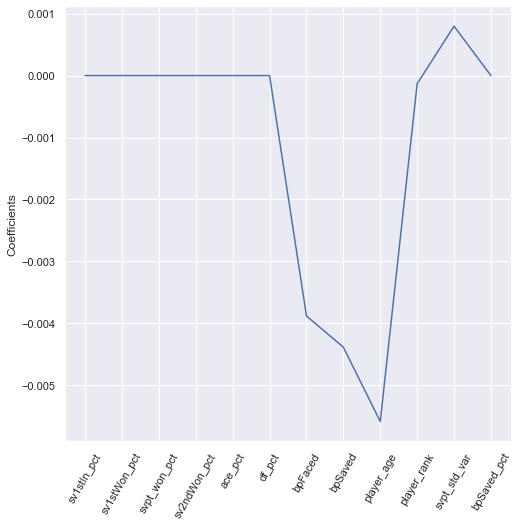

In [1364]:
plot_lasso_features(names, X, y, 0.01)

In [1366]:
# split data into train and testing set
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
#model_columns=['sv1stIn_pct','svpt_won_pct', 'bpSaved_pct']
names= df[model_columns].columns
X = df[model_columns].values
y=df['player_hand_flag'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p_test_size , random_state=p_random_state)  

### Choose the best n_neighbors 

[0.5572789260653898, 0.5539896215613735, 0.5608204163473817, 0.5586468114075517, 0.5657867010736309, 0.5658504316507716, 0.5651051668106446, 0.5656021383780401, 0.5686425723395173, 0.5679603057742872, 0.5651666624045901, 0.5708165627317923, 0.5680866488390367, 0.5693262646195804, 0.5695739799528183, 0.5706323083790235, 0.567340613955045, 0.5728047955163299, 0.569762280264721, 0.5727439550193356, 0.5698866191011269, 0.5708788665895705, 0.5690793966311686, 0.5737370498526053, 0.5708187966147881, 0.5759096525586767, 0.5721839461438841, 0.5750393168190735, 0.5711897336037605, 0.5744185843069308]


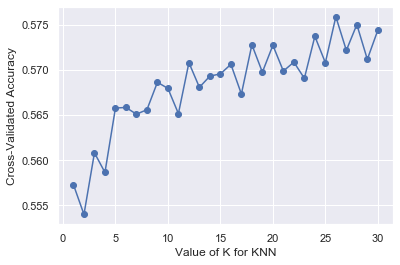

In [1367]:
# use cross val search best k from the list of k
k_range, k_scores = knn_cross_val_k_search(X_train, y_train, n_CV)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}

Mean Test Score
0.5683017696367588
{'n_neighbors': 26}
0.5759081030735796


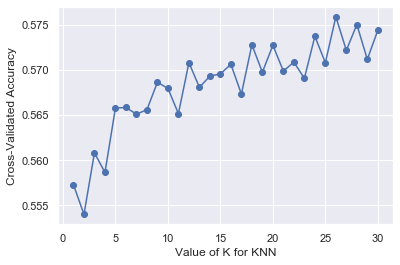

In [1368]:
# use grid serach to get the best k
g, k = knn_k_grid_search(X_train, y_train, n_CV)

In [1369]:
# exam performance using cross_val_scores
knn_cross_val_scores(X_test, y_test, k, n_CV)

CV Scores:
[0.61803922 0.61698529 0.60617647 0.596367   0.60301508 0.60502017
 0.54914969 0.65551897 0.6115058  0.57199792]
Average CV Score:
0.6033775614647177




array([0.61803922, 0.61698529, 0.60617647, 0.596367  , 0.60301508,
       0.60502017, 0.54914969, 0.65551897, 0.6115058 , 0.57199792])

              precision    recall  f1-score   support

         0.0       0.56      0.67      0.61      1994
         1.0       0.60      0.49      0.54      2033

    accuracy                           0.58      4027
   macro avg       0.58      0.58      0.58      4027
weighted avg       0.58      0.58      0.58      4027

[[1335  659]
 [1031 1002]]
0.41966724608889994
-0.6788264449028341
ROC AUC Score: 0.6158655504141545



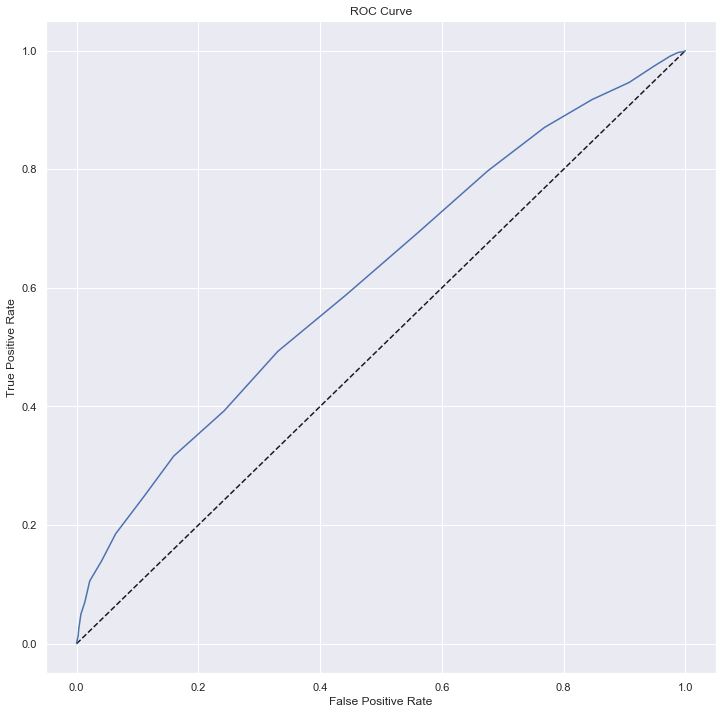

In [1370]:
# exam testing score
knn = KNeighborsClassifier(n_neighbors=k)
run_train_testing_split(knn, X_train, X_test, y_train, y_test)

In [1371]:
get_cross_val_scores(KNeighborsClassifier(n_neighbors=k), X_test, y_test, n_CV)

CV Scores:
[0.61803922 0.61698529 0.60617647 0.596367   0.60301508 0.60502017
 0.54914969 0.65551897 0.6115058  0.57199792]
Average CV Score:
0.6033775614647177




array([0.61803922, 0.61698529, 0.60617647, 0.596367  , 0.60301508,
       0.60502017, 0.54914969, 0.65551897, 0.6115058 , 0.57199792])

### Exam learninig performance 

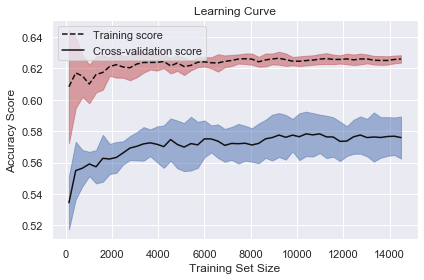

In [1372]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=k), X_train, y_train)

•	Seems overfitting because the model performs well on the training set but poor on the test set.

•	The testing curve shows higher variability than training. The variability of both training and testing are narrow. 

•	The gap between training score and Cross-validation score are not decreasing even the data size increases.


# Logictics Regression

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2014
           1       0.79      0.80      0.80      2013

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

[[1580  434]
 [ 394 1619]]
0.2056121182021356
0.17755147647540215
ROC AUC Score: 0.8851019761816318



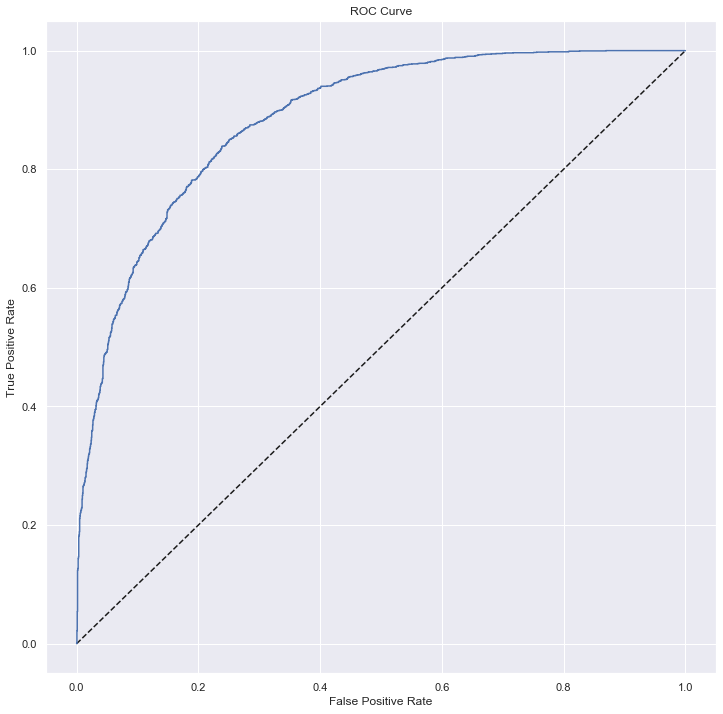

In [1313]:
# Logictics Regression
model_columns=['sv1stWon_pct','sv2ndWon_pct', 'svpt_won_pct','ace_pct','df_pct','bpSaved_pct']
X=df[model_columns]
y=df['won_flag']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y) 
logisticreg = LogisticRegression()

run_train_testing_split(logisticreg, X_train, X_test, y_train, y_test)

In [1314]:
get_cross_val_scores(logisticreg, X_test, y_test, n_CV)

CV Scores:
[0.89991177 0.86685129 0.88765807 0.88672972 0.87445855 0.87289919
 0.9089874  0.8650776  0.89757679 0.86205787]
Average CV Score:
0.8822208252500037




array([0.89991177, 0.86685129, 0.88765807, 0.88672972, 0.87445855,
       0.87289919, 0.9089874 , 0.8650776 , 0.89757679, 0.86205787])

### Exam learninig performance¶ 

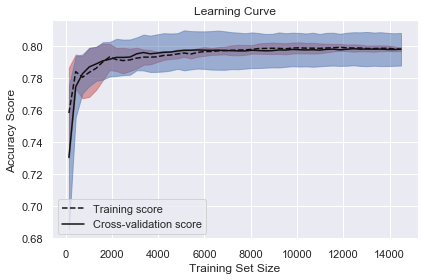

In [1315]:
#plot_learning_curve(LogisticRegression(), X_train, y_train)
plot_learning_curve(logisticreg, X_train, y_train)

# Random Forest

## Predict won_flag 

In [1316]:
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
names= df[model_columns].columns

X=df[model_columns]
y=df['won_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

In [1317]:
# randm forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1318]:
y_pred = rf.predict(X_test)

In [1319]:
# use AUC (Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7834544675103388

### Exam feature importane

In [1320]:
# randon forest
# Feature Importance

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42, stratify=y) 

features = model_columns # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('sv1stIn_pct', 0.0527394513282467)
('sv1stWon_pct', 0.11007642758373118)
('svpt_won_pct', 0.23997242783059763)
('sv2ndWon_pct', 0.06139384937232547)
('ace_pct', 0.055241350752666375)
('df_pct', 0.039609249968851803)
('bpFaced', 0.08790181349216751)
('bpSaved', 0.033794045501578523)
('player_age', 0.06976416148736311)
('player_rank', 0.08260117569641051)
('svpt_std_var', 0.06977933474980787)
('bpSaved_pct', 0.09712671223625344)


## Choose Model Parameters
### N_estimators

n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

In [1321]:
def choose_N_estimators(X_train, X_test, y_train, y_test):
    # n_estimators represents the number of trees in the forest
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    train_results = []
    test_results = []
    
    for estimator in n_estimators:
        rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
    
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
    
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimators')
    plt.show()

### max_depth 
max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 1 to 32 and plot the training and test errors.

In [1322]:
def choose_max_depth(X_train, X_test, y_train, y_test):
    # max_depth
    max_depths = np.linspace(1, 32, 32, endpoint=True)
    train_results = []
    test_results = []
    for max_depth in max_depths:
        rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
    
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('Tree depth')
    plt.show()

### min_samples_split

min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

In [1323]:
def choose_min_samples_split (X_train, X_test, y_train, y_test):
    # min_samples_split
    min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

    train_results = []
    test_results = []

    for min_samples_split in min_samples_splits:
        rf = RandomForestClassifier(min_samples_split=min_samples_split)
    
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
    
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
    
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min samples split')
    plt.show()

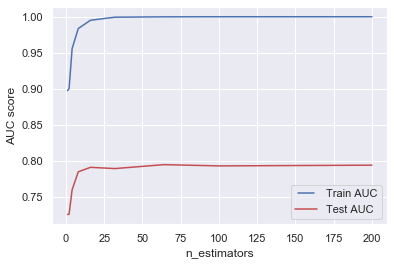

In [1324]:
choose_N_estimators(X_train, X_test, y_train, y_test)

In [1325]:
print('From the above plot, we can stop at 30 trees')

From the above plot, we can stop at 30 trees


C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

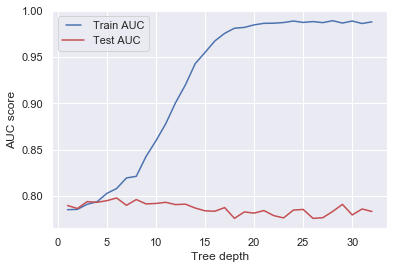

In [1326]:
choose_max_depth(X_train, X_test, y_train, y_test)

We see that our model overfits for large depth values. The trees perfectly predicts all of the train data, however, it fails to generalize the findings for new data

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

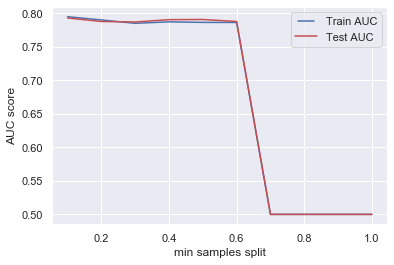

In [1327]:
choose_min_samples_split (X_train, X_test, y_train, y_test)

Use default value 2.

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2014
           1       0.80      0.79      0.80      2013

    accuracy                           0.80      4027
   macro avg       0.80      0.80      0.80      4027
weighted avg       0.80      0.80      0.80      4027

[[1610  404]
 [ 416 1597]]
0.2036255276881053
0.1854978390215335
ROC AUC Score: 0.8876550189409356



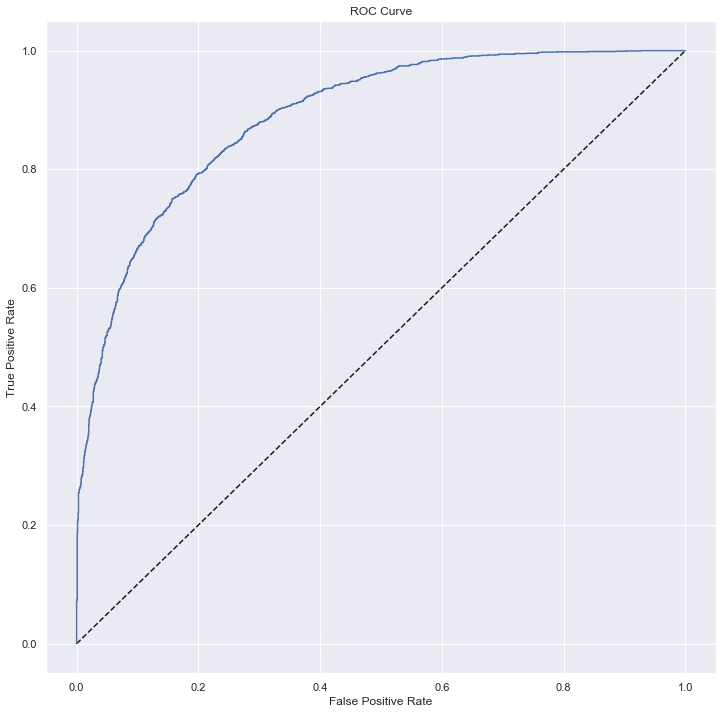

In [1329]:
# randm forest
# Using the actual data

clf = RandomForestClassifier(n_estimators=30,  random_state=50, max_features='auto', n_jobs=-1, max_depth=5)

run_train_testing_split(clf, X_train, X_test, y_train, y_test)

In [1330]:
get_cross_val_scores(clf, X_test, y_test, n_CV)

CV Scores:
[0.90420057 0.86868934 0.88998628 0.89106448 0.87205762 0.87594366
 0.91304671 0.8690874  0.9049281  0.87339422]
Average CV Score:
0.8862398379634033




array([0.90420057, 0.86868934, 0.88998628, 0.89106448, 0.87205762,
       0.87594366, 0.91304671, 0.8690874 , 0.9049281 , 0.87339422])

### Exam learninig performance¶ 

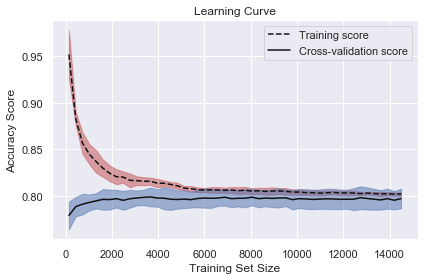

In [1331]:
plot_learning_curve(clf, X_train, y_train)

•	When training set size less than 400, the plot shows high bias. 

•	When the training size is increasing, the variance is getting smaller. More training data may not help. 

•	Training score and Cross-validation score are converging when the training set size increases, and the accuracy score is at 0.80. 

•	The testing curve shows higher variability than training. The variability of both training and testing are not narrow.

## Predict player hand

### Data set 1 of selected predictor variables 

In [1332]:
model_columns=['sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpFaced','bpSaved', 'player_age', 'player_rank', 'svpt_std_var', 'bpSaved_pct']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

In [1333]:
# randm forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1334]:
y_pred = rf.predict(X_test)

In [1335]:
# use AUC (Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5830390692869734

In [1336]:
# randon forest
# Feature Importance

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42, stratify=y) 

features = model_columns # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('sv1stIn_pct', 0.08632160482375426)
('sv1stWon_pct', 0.07530170982550247)
('svpt_won_pct', 0.07492767480007279)
('sv2ndWon_pct', 0.07083289069995548)
('ace_pct', 0.0811214273237346)
('df_pct', 0.062388589596813225)
('bpFaced', 0.05344915271375736)
('bpSaved', 0.0439082750647763)
('player_age', 0.14136430447322004)
('player_rank', 0.16086009826395736)
('svpt_std_var', 0.0892698083826842)
('bpSaved_pct', 0.06025446403177199)


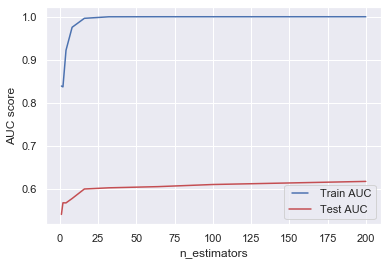

In [1337]:
choose_N_estimators(X_train, X_test, y_train, y_test)

From the plot, we can stop at 70 trees

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

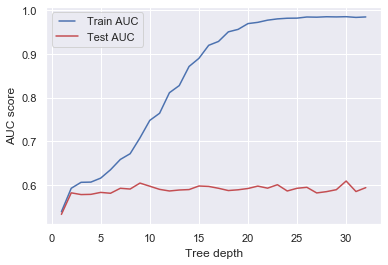

In [1338]:
choose_max_depth(X_train, X_test, y_train, y_test)

We see that the model overfits for large depth values. Choose 5

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

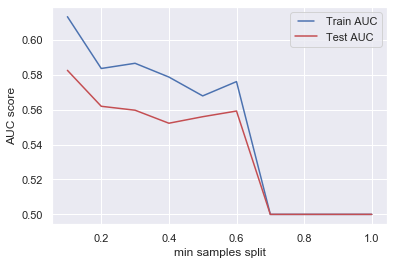

In [1339]:
choose_min_samples_split (X_train, X_test, y_train, y_test)

Increase this value can cause underfitting.  Use default value 2.

              precision    recall  f1-score   support

         0.0       0.57      0.74      0.64      2014
         1.0       0.63      0.43      0.51      2013

    accuracy                           0.59      4027
   macro avg       0.60      0.59      0.58      4027
weighted avg       0.60      0.59      0.58      4027

[[1493  521]
 [1140  873]]
0.4124658554755401
-0.6498635236405279
ROC AUC Score: 0.6371388852301154



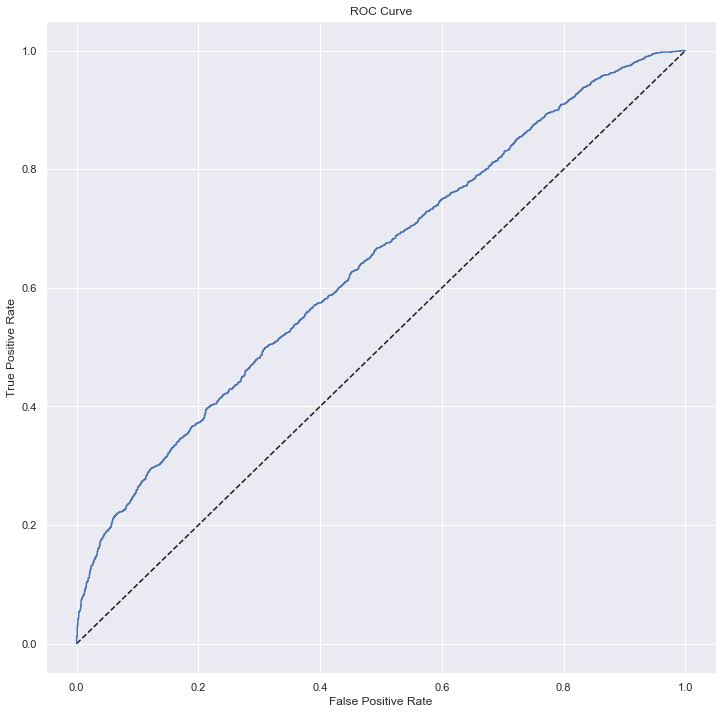

In [1340]:
# randm forest
# Using the actual data

clf = RandomForestClassifier(n_estimators=70,  random_state=50, max_features='auto', n_jobs=-1, max_depth=5)

run_train_testing_split(clf, X_train, X_test, y_train, y_test)

In [1341]:
get_cross_val_scores(clf, X_test, y_test, n_CV)

CV Scores:
[0.61731693 0.60653367 0.6364082  0.66292301 0.6211975  0.6512215
 0.61562833 0.5734759  0.58057969 0.6452068 ]
Average CV Score:
0.621049152693226




array([0.61731693, 0.60653367, 0.6364082 , 0.66292301, 0.6211975 ,
       0.6512215 , 0.61562833, 0.5734759 , 0.58057969, 0.6452068 ])

### Exam learninig performance¶ 

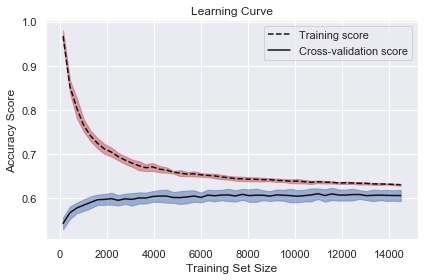

In [1342]:
plot_learning_curve(clf, X_train, y_train)

•	When training set size less than 400, the plot shows high bias. 

•	When the training size is increasing, the variance is getting smaller. Get more training data may help to decease. 

•	Training score and Cross-validation score are converging when the training set size increases, but the accuracy score is low at 0.60. 

•	The testing curve shows higher variability than training. The variability of both training and testing are narrow.


### Data set 2 of selected predictor variables

Will apply more data to predict play hand

In [1347]:
model_columns=['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

In [1345]:
df_all.columns

Index(['Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'tourney_level',
       'tourney_date', 'match_num', 'player_id', 'player_name', 'player_hand',
       'player_ht', 'player_ioc', 'player_age', 'score', 'best_of', 'round',
       'minutes', 'ace', 'df', 'svpt', 'sv1stIn', 'sv1stWon', 'sv2ndWon',
       'SvGms', 'bpSaved', 'bpFaced', 'player_rank', 'player_rank_points',
       'ace_pct', 'df_pct', 'sv1stIn_pct', 'sv2ndIn_pct', 'sv1stWon_pct',
       'sv2ndWon_pct', 'GmsWon', 'GmsLoss', 'year', 'opponent_id',
       'opponent_name', 'won_flag', 'player_age_bucket', 'svpt_won_pct',
       'svpt_std_var', 'bpSaved_pct', 'player_hand_flag'],
      dtype='object')

In [1348]:
# randm forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1349]:
y_pred = rf.predict(X_test)

In [1350]:
# use AUC (Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6930465874497002

In [1351]:
# randon forest
# Feature Importance

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42, stratify=y) 

features = model_columns # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('sv1stIn', 0.039749470988107494)
('sv1stWon', 0.037532537266525466)
('svpt', 0.040362611705480875)
('sv2ndWon', 0.03451751023495668)
('ace', 0.03486317043693845)
('df', 0.02548512684362813)
('SvGms', 0.02515675818769956)
('sv1stIn_pct', 0.04651068929234982)
('sv1stWon_pct', 0.039095578197957365)
('svpt_won_pct', 0.03943707500197849)
('sv2ndWon_pct', 0.036833485955372586)
('ace_pct', 0.039329067830918295)
('df_pct', 0.029378030420734818)
('bpSaved_pct', 0.03353116620292101)
('bpFaced', 0.02972065856573619)
('bpSaved', 0.025749191800775794)
('player_age', 0.09131730449585697)
('player_rank', 0.09353813450870921)
('player_rank_points', 0.09636379825516585)
('player_ht', 0.12157142707278158)
('svpt_std_var', 0.03995720673540554)


### Find the best params

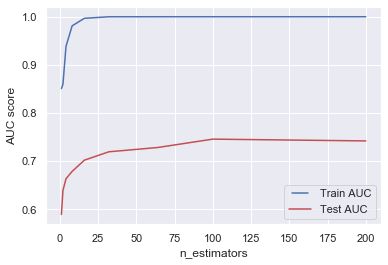

In [1352]:
choose_N_estimators(X_train, X_test, y_train, y_test)

We can stop at 100 trees

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

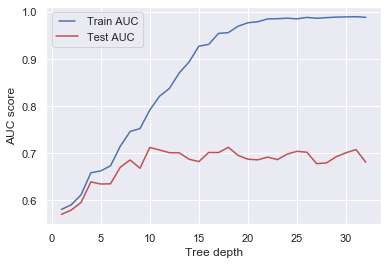

In [1353]:
choose_max_depth(X_train, X_test, y_train, y_test)

We will choose 4 a the MAX depth

C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yihon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

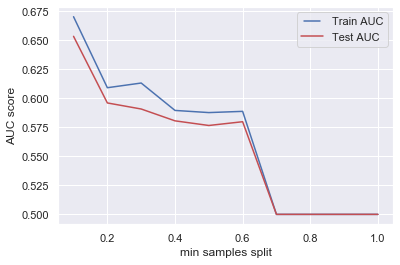

In [1354]:
choose_min_samples_split (X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

         0.0       0.60      0.80      0.69      2014
         1.0       0.70      0.46      0.56      2013

    accuracy                           0.63      4027
   macro avg       0.65      0.63      0.62      4027
weighted avg       0.65      0.63      0.62      4027

[[1621  393]
 [1086  927]]
0.36727092128135086
-0.4690837757160391
ROC AUC Score: 0.707365628874086



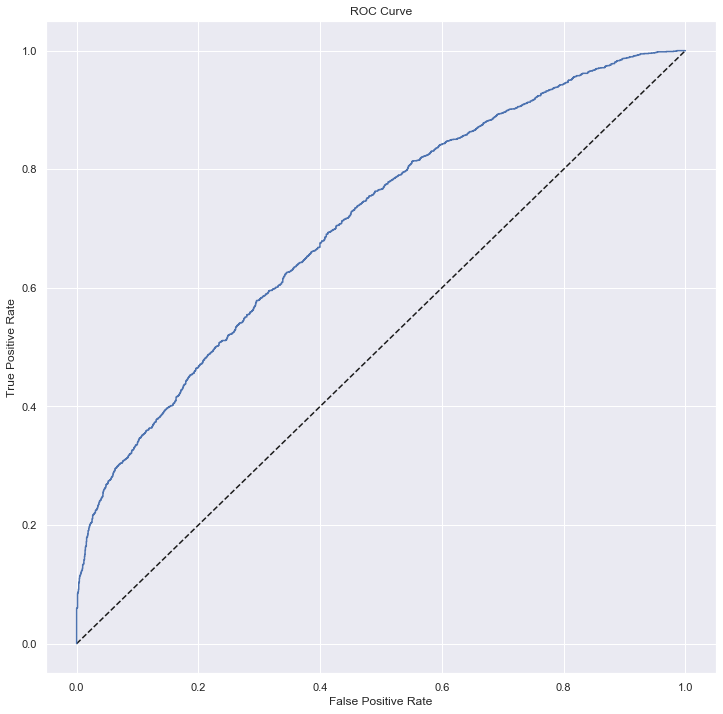

In [1355]:
# randm forest
# Using the actual data

clf = RandomForestClassifier(n_estimators=100,  random_state=50, max_features='auto', n_jobs=-1, max_depth=4)

run_train_testing_split(clf, X_train, X_test, y_train, y_test)

In [1356]:
get_cross_val_scores(clf, X_test, y_test, n_CV)

CV Scores:
[0.68760416 0.63545241 0.68088913 0.71856066 0.69176506 0.71901686
 0.68141878 0.65372144 0.66396871 0.70837356]
Average CV Score:
0.684077075303127




array([0.68760416, 0.63545241, 0.68088913, 0.71856066, 0.69176506,
       0.71901686, 0.68141878, 0.65372144, 0.66396871, 0.70837356])

### Exam learninig performance¶ 

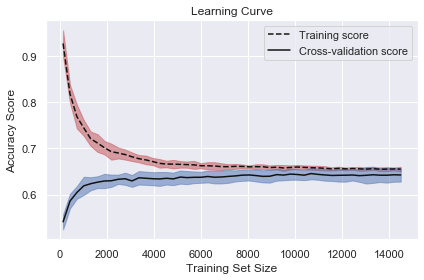

In [1357]:
plot_learning_curve(clf, X_train, y_train)

### Compared the performance betwen KNeighborClassifier, LogisticRegression and RandomForestClassifier, RandomForestClassifier model performed best. 

### An ensemble is just a collection of predictors which come together (e.g. mean of all predictions) to give a final prediction. The reason we use ensembles is that many different predictors trying to predict same target variable will perform a better job than any single predictor alone.

### TIt takes more than one features to predict player hand.  As a bagging ensemble, Random Forest model performs better than classifier (KNN) and regressor (Logistic).  To further reduce variance and bias, I would like to try boosting ensemble Gradient Boosting (GBM) algorithm.



## Gradient Boosting 

In [1377]:
model_columns=['sv1stIn','sv1stWon','svpt','sv2ndWon','ace','df', 'SvGms',
               'sv1stIn_pct','sv1stWon_pct','svpt_won_pct','sv2ndWon_pct','ace_pct','df_pct','bpSaved_pct',
               'bpFaced','bpSaved', 
               'player_age', 'player_rank', 'player_rank_points','player_ht',
               'svpt_std_var']
names= df[model_columns].columns

X=df[model_columns]
y=df['player_hand_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_test_size,  random_state= p_random_state, stratify=y)

Ffirst fit a gradient boosting classifier with default parameters to get a baseline idea of the performance

In [1381]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [1383]:
y_pred = model.predict(X_test)

In [1384]:
# Use AUC(Area Under Curve) as the evaluation metric
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7059658397180986

### Functions to tune params 

#### learning_rate 

In [1401]:
def choose_GB_learning_rate (X_train, X_test, y_train, y_test):
    learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
    train_results = []
    test_results = []
    
    for eta in learning_rates:
        model = GradientBoostingClassifier(learning_rate=eta)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
    line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('learning rate')
    plt.show()

#### n_estimators 

In [1428]:
def choose_GB_n_estimators (X_train, X_test, y_train, y_test):
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    train_results = []
    test_results = []
    for estimator in n_estimators:
        model = GradientBoostingClassifier(n_estimators=estimator)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimators')
    plt.show()

#### ma_depth 

In [1429]:
def choose_GB_max_depth (X_train, X_test, y_train, y_test):
    max_depths = np.linspace(1, 32, 32, endpoint=True)
    train_results = []
    test_results = []
    for max_depth in max_depths:
        model = GradientBoostingClassifier(max_depth=max_depth)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('tree depth')
    plt.show()

#### min_sample_split 

In [1430]:
def choose_GB_min_samples_split (X_train, X_test, y_train, y_test):
    min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
    train_results = []
    test_results = []
    
    for min_samples_split in min_samples_splits:
        model = GradientBoostingClassifier(min_samples_split=min_samples_split)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min_samples_split')
    plt.show()

#### min_sample_leaf 

In [1441]:
def choose_GB_min_samples_leaf (X_train, X_test, y_train, y_test):
    min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
    train_results = []
    test_results = []
    
    for min_samples_leaf in min_samples_leafs:
        model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
    line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('min_samples_leaf')
    plt.show()

#### max_features 

In [1432]:
def choose_GB_max_features (X_train, X_test, y_train, y_test):
    max_features = list(range(1,X_train.shape[1]))
    train_results = []
    test_results = []
    
    for max_feature in max_features:
        model = GradientBoostingClassifier(max_features=max_feature)
        model.fit(X_train, y_train)
        
        # trainng
        train_pred = model.predict(X_train)        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        # testing
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
        
    #from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
    line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('max_features')
    plt.show()

In [1406]:
# set range for tuning params 
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features = list(range(1,X_train.shape[1]))

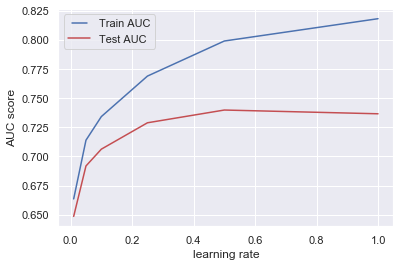

In [1414]:
choose_GB_learning_rate (X_train, X_test, y_train, y_test)

Using a high learning rate will result in overfitting.  For this data, 0.07 is optimal

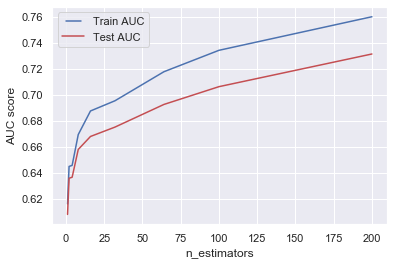

In [1433]:
choose_GB_n_estimators (X_train, X_test, y_train, y_test)

To avoid overfitting, using 25 trees

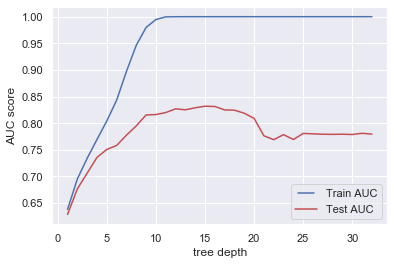

In [1434]:
choose_GB_max_depth (X_train, X_test, y_train, y_test)

The tree can grow to max depth of 10 or 15.  Overfit for large depth values.

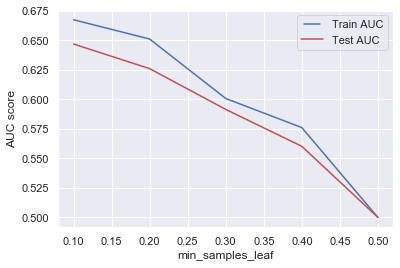

In [1446]:
choose_GB_min_samples_split (X_train, X_test, y_train, y_test)

We can split samples half.  Overall, even with all of the samples at each node, the model cannot learn enough about the dta.  This is an underfitting case. Will use the default value

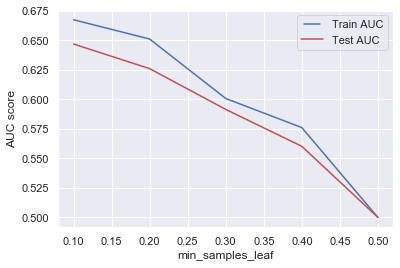

In [1442]:
choose_GB_min_samples_leaf (X_train, X_test, y_train, y_test)

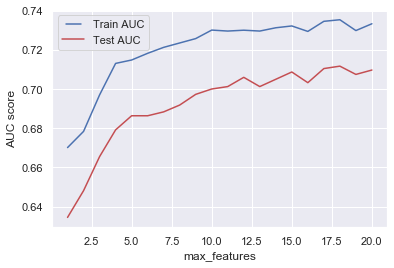

In [1447]:
choose_GB_max_features (X_train, X_test, y_train, y_test)

Try to use max_features = 6 seems to get us the optimal performance.

### Use learning_rate = 0.07, n_estimators=50, max_depth=15, max_features=6 

              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80      2014
         1.0       0.82      0.74      0.78      2013

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

[[1685  329]
 [ 520 1493]]
0.2108269183014651
0.15669227479180725
ROC AUC Score: 0.8750546966071084



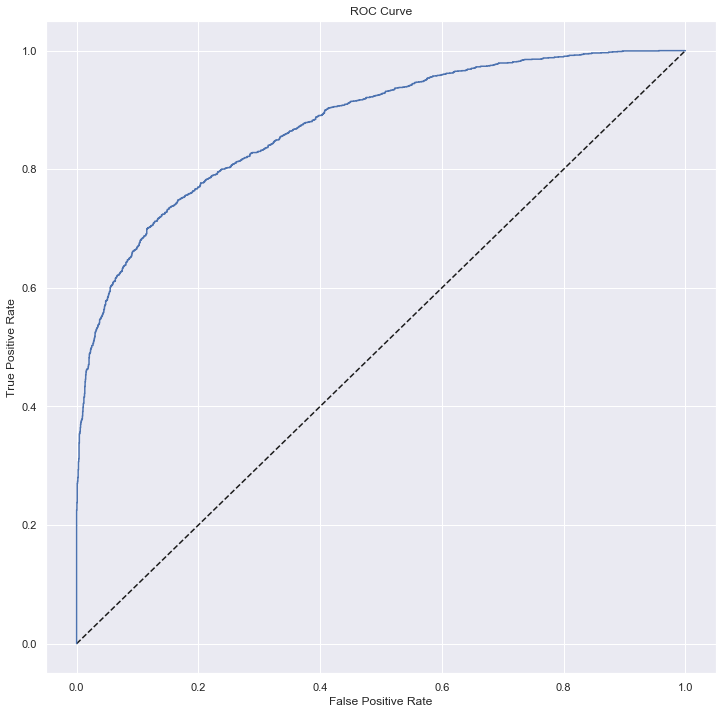

In [1449]:
m = GradientBoostingClassifier(learning_rate=0.07, n_estimators=50,max_depth=15,max_features=6)
run_train_testing_split(m, X_train, X_test, y_train, y_test)

In [1451]:
get_cross_val_scores(m, X_test, y_test, n_CV)

CV Scores:
[0.76100382 0.74512303 0.75923929 0.81995961 0.77762927 0.82087077
 0.77220861 0.73862033 0.74272914 0.7720601 ]
Average CV Score:
0.7709443963371212




array([0.76100382, 0.74512303, 0.75923929, 0.81995961, 0.77762927,
       0.82087077, 0.77220861, 0.73862033, 0.74272914, 0.7720601 ])

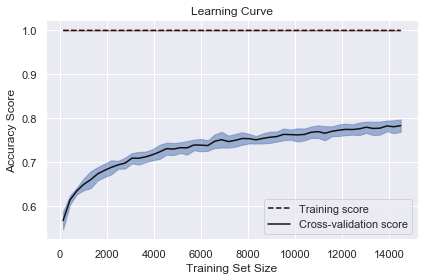

In [1450]:
plot_learning_curve(m, X_train, y_train)

•	Training score (red line) is at its maximum regardless of training examples

     o This shows severe overfitting
     
•	Cross-validation score (blue line) increases over time

•	Huge gap between cross-validation score and training score indicates high variance scenario

     o Reduce complexity of the model or gather more data


### change n_estimators to 25 from 50 and reduce max_depth to 10 

              precision    recall  f1-score   support

         0.0       0.77      0.83      0.79      2014
         1.0       0.81      0.75      0.78      2013

    accuracy                           0.79      4027
   macro avg       0.79      0.79      0.79      4027
weighted avg       0.79      0.79      0.79      4027

[[1662  352]
 [ 507 1506]]
0.21331015644400297
0.14675932160914296
ROC AUC Score: 0.8757907267113316



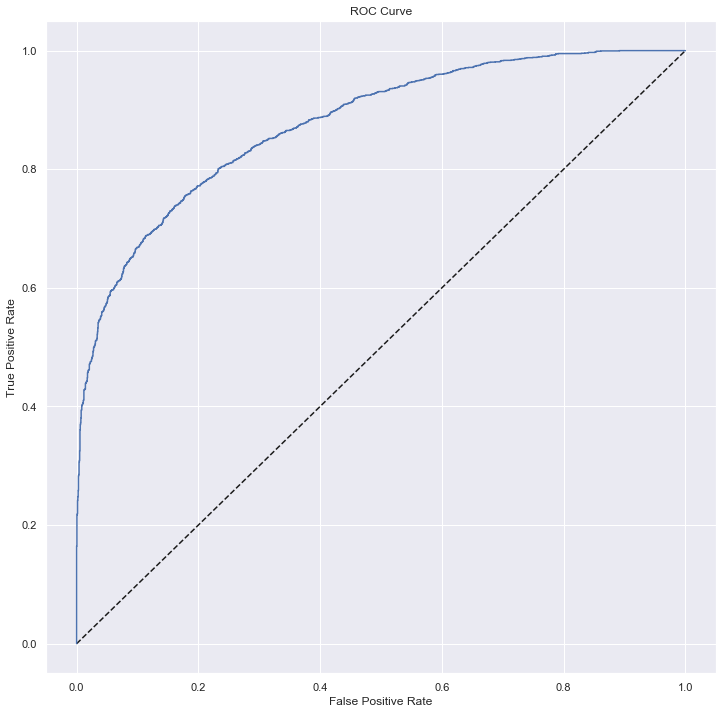

In [1452]:
gb = GradientBoostingClassifier(learning_rate=0.07, n_estimators=25,max_depth=10,max_features=6)
run_train_testing_split(m, X_train, X_test, y_train, y_test)

In [1454]:
get_cross_val_scores(gb, X_test, y_test, n_CV)

CV Scores:
[0.78678561 0.77413979 0.75710715 0.80845771 0.79886636 0.80577213
 0.79661395 0.73176407 0.73302641 0.77889161]
Average CV Score:
0.7771424788595109




array([0.78678561, 0.77413979, 0.75710715, 0.80845771, 0.79886636,
       0.80577213, 0.79661395, 0.73176407, 0.73302641, 0.77889161])

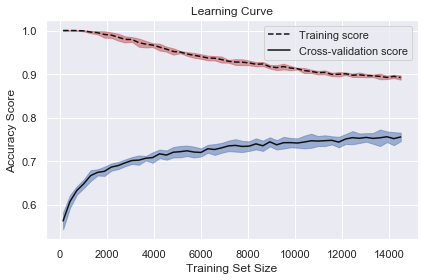

In [1455]:
plot_learning_curve(gb, X_train, y_train)

• The training and test scores have not yet converged, so potentially this model would benefit from more training data.

• Cross-validation score (blue line) increases over time

• Huge gap between cross-validation score and training score indicates high variance scenario

    o Reduce complexity of the model or gather more data

### Gradient Boosting model has the same RO AUC score at 87% as Random Forest model at .  However, Random Forest model learning curve shows better performace than Gradient Boosting.  Gradient Boosting learning curve shows the potential to be further tuned.